In [1]:
# Goal: compare qiskit aer simulator with the cirq one

In [ ]:
# why is 

In [39]:
import numpy as np
import cirq
import qiskit
from qiskit.circuit import qpy_serialization
from qiskit import QuantumCircuit
from typing import List
import math
import pandas as pd
from IPython.display import display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# N QUBITS = 10

# Randomly generate an encoding for a circit

    # Preselection
    # IDEA: maybe we should keep only programs which output a subset of states and not superpositions
    # https://quantumcomputing.stackexchange.com/a/14398/18188
    # how-many-shots-should-one-take-to-get-a-reliable-estimate-in-a-quantum-program

# Convert that encoding to a qasm string

# for each platform in (qiskit, cirq, etc)

    # create a circuit object form the qasm file
    
    # perform 30 evaluations [N_EVALUATION]
        
        # run the circuit for 1024 or 8096 shots
        
    # save the statistics for each combination to a dataframe
    
# compare the distribution of the occurrences of each basis state (e.g. 0000)
# for cirq (state: 0000): [512, 493, 502, etc ... until N_EVALUATION]
# for qiskit (state: 0000): [400, 475, 480, etc ... until N_EVALUATION]
# check if the two sequences come from the same distribution with a test
from scipy.stats import ttest_ind
data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]
stat, p = ttest_ind(data1, data2)

# if yes... then bug discovered!

# next steps:
    
    # which platform is buggy: cirq or qiskit?
    
    # where was the mistake in that platform?
    
        # delta debugging (style)
        
        # - remove operations
        # - track the function called with cProfile
        # - continue until the removed operation cause the Cirq an Qiskit result 
        # to agree again

In [3]:
N_QUBITS = 10
N_OPS = 100
N_EVALUATIONS = 100
TOP_K_SOLUTION_TO_COMPARE = 5
CLASSICAL_INPUT = 127
SEED_NP = 42

QASM_HEADER = """
OPENQASM 2.0;
include "qelib1.inc";
"""

gate_set = {
   "cx": 3, 
    "rx": 1, 
    "ry": 1, 
    "rz": 1, 
    "p": 1
}

In [4]:
# Randomly generate an encoding for a circit
def random_circuit_encoding(n_ops=N_OPS, random_state=None):
    if random_state is not None:
        assert isinstance(random_state, int)
        np.random.seed(random_state)
    return np.random.rand(3 * n_ops)

random_circuit_encoding(random_state=42)

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914,
       0.61185289, 0.13949386, 0.29214465, 0.36636184, 0.45606998,
       0.78517596, 0.19967378, 0.51423444, 0.59241457, 0.04645041,
       0.60754485, 0.17052412, 0.06505159, 0.94888554, 0.96563203,
       0.80839735, 0.30461377, 0.09767211, 0.68423303, 0.44015249,
       0.12203823, 0.49517691, 0.03438852, 0.9093204 , 0.25877998,
       0.66252228, 0.31171108, 0.52006802, 0.54671028, 0.18485446,
       0.96958463, 0.77513282, 0.93949894, 0.89482735, 0.59789998,
       0.92187424, 0.0884925 , 0.19598286, 0.04522729, 0.32533033,
       0.38867729, 0.27134903, 0.82873751, 0.35675333, 0.28093451,
       0.54269608, 0.14092422, 0.80219698, 0.07455064, 0.98688694,
       0.77224477, 0.19871568, 0.00552212, 0.81546143, 0.70685

In [5]:
def slot_to_gate(gates, gate_weights):
    mapping_dict = dict()
    slot_to_assign = 0
    for gate, number_of_slots in zip(gates, gate_weights):
        for slot in range(number_of_slots):
            mapping_dict[slot_to_assign] = gate
            slot_to_assign += 1
    return mapping_dict


def param_to_gate(param, gate_set):
    map_slot_to_gate = slot_to_gate(gate_set.keys(), gate_set.values())
    slots = sum(gate_set.values())
    op_type = map_slot_to_gate[int(param / (float(1) / slots))]
    return op_type

#def param_to_qubit(param, available_indices):
    

In [6]:
# Convert that encoding to a qasm string
def encoding_to_circuit(encoding: List[float], n_qubits: int, classical_input: int = None):
    """Convert encoding to a qasm string.
    
    We have a list to encode the single operation, the final list looks like:
    (0.23, 0.75, 0.76, 0.44, etc)
    (gate_type, qubit, parameter, gate_type, qubit, parameter, etc...)
    The single operation is made of three floats: 
    (gate_type, qubit, parameter)
    The first float encodes the gate. We divide the interval uniformly 
    on the available gates:
    - CNOT
    - pauli X
    - pauli Y
    - pauli Z
    - pahse shift
    The second float encodes the qubit on which it applies to. We divide the
    interval uniformly on the available qubits.
    The third float is used only by:
    - cnot gate: to select a target qubit (similarly to the first flaot)
    - phase shift: to select the rotation
    Based on the second digit we decide on which qubit it acts on
    
    """
    circuit_qasm = QASM_HEADER
    qubits = range(n_qubits)
    
    # add quantum and classical registers
    circuit_qasm += f"qreg q[{n_qubits}];\n"
    circuit_qasm += f"creg c[{n_qubits}];\n"
    
    
    if classical_input != None:
        assert isinstance(classical_input, int)
        format_string = "{0:" + str(n_qubits) + "b}"
        string_input = format_string.format(classical_input).zfill(n_qubits)
        for i, c in enumerate(string_input):
            if c == "1": 
                circuit_qasm += f"x q[{i}];\n"
    
    circuit_qasm += f"barrier q;\n"
    
    
    # get the single chunks
    n = 3  # number of parameters per operation
    chunks = [encoding[i:i + n] for i in range(0, len(encoding), n)]
    for op in chunks:
        # discard incomplete sequences
        if len(op) != 3: 
            continue
        # get the type of gate
        op_type = param_to_gate(param=op[0], gate_set=gate_set)
        #print(op_type, " : ", op[0])        
        
        try:
            # get target qubit
            qubit = qubits[int(op[1] / (float(1) / (len(qubits))))]
            #print(qubit, " : ", op[1])

            # extra parameter
            if op_type == "cx":
                # get second target qubit
                index_target = int(op[2] / (float(1) / (len(qubits) - 1)))
                if index_target >= qubit:
                    index_target += 1
                second_target_qubit = qubits[index_target]
                #print(second_target_qubit, " : ", op[2])
                #assert qubit == second_target_qubit, "Invalid encoding CNOT gate with same control and target qubit."
                circuit_qasm += f"cx q[{qubit}], q[{second_target_qubit}];\n"
            elif op_type == "p":
                # get rotation parameter
                parameter = 2 * math.pi * op[2]
                #print(parameter, " : ", op[2])
                circuit_qasm += f"U(0,{parameter},0) q[{qubit}];\n"
            else:
                parameter = 2 * math.pi * op[2]
                # call the simple X, Y, Z gate on a single qubit
                circuit_qasm += f"{op_type}({parameter}) q[{qubit}];\n"
        
        except IndexError: 
            print(f"op[0]: {op[0]}")
            print(f"op[1]: {op[1]}")
            print(f"op[2]: {op[2]}")
            print(f"op_type: {op_type}")
            print(f"qubit: {qubit}")
            print(f"second_target_qubit: {second_target_qubit}")
    circuit_qasm += f"barrier q;\n"
    # Measure
    circuit_qasm += f"measure q -> c;\n"
    return circuit_qasm

random_circuit_qasm_str = encoding_to_circuit(
        encoding=random_circuit_encoding(), 
        n_qubits=10, 
        classical_input=30)
print(random_circuit_qasm_str)
random_circuit = QuantumCircuit.from_qasm_str(random_circuit_qasm_str)
random_circuit.draw()


OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
x q[5];
x q[6];
x q[7];
x q[8];
barrier q;
cx q[5], q[4];
ry(6.131459447659643) q[7];
rx(4.996302215442763) q[3];
cx q[4], q[0];
cx q[9], q[7];
ry(1.0888403256868147) q[4];
cx q[2], q[5];
rz(1.7588765482722726) q[6];
U(0,3.4831092377150936,0) q[7];
ry(1.556539713366733) q[4];
cx q[7], q[0];
cx q[0], q[1];
rz(2.979322035970566) q[7];
cx q[4], q[5];
cx q[4], q[3];
ry(0.2846534885560305) q[6];
cx q[6], q[4];
rz(1.0237471982717627) q[6];
cx q[6], q[0];
ry(3.6158108990909743) q[9];
cx q[6], q[4];
rx(2.425954420893106) q[9];
U(0,1.2301919813841253,0) q[9];
cx q[1], q[0];
cx q[6], q[0];
cx q[8], q[0];
rz(0.7424515087377991) q[2];
ry(5.513319262854466) q[6];
rz(1.7720754824967075) q[8];
cx q[7], q[8];
U(0,2.33745857065829,0) q[4];
rz(5.8481207527820835) q[3];
U(0,4.717862060733784,0) q[4];
rz(5.670907162201281) q[1];
rx(2.0109309507642283) q[8];
U(0,0.06809497254534375,0) q[3];
U(0,2.006306756090162,0) q[0];
U(0,3.6030165132363225,0)

░                                    ┌───┐                     »
 q_0: ──────░────────────────────────────────────┤ X ├─────────────────────»
            ░                                    └─┬─┘                     »
 q_1: ──────░──────────────────────────────────────┼───────────────────────»
            ░                                      │        ┌─────────────┐»
 q_2: ──────░──────────────────────■───────────────┼────────┤ Rz(0.74245) ├»
            ░ ┌────────────┐       │               │        └─────────────┘»
 q_3: ──────░─┤ Rx(4.9963) ├───────┼───────────────┼───────────────────────»
            ░ └───┬───┬────┘       │               │         ┌────────────┐»
 q_4: ──────░─────┤ X ├────────────┼───────────────■─────────┤ Ry(1.0888) ├»
      ┌───┐ ░     └─┬─┘          ┌─┴─┐                       └────────────┘»
 q_5: ┤ X ├─░───────■────────────┤ X ├─────────────────────────────────────»
      ├───┤ ░ ┌────────────┐┌────┴───┴────┐                                »
 q_6: ┤ X ├─░─┤ Rz(1.7589) ├┤ Ry(0.28465) ├────────────────────────────────»
      ├───┤ ░ ├────────────┤└────┬───┬────┘┌───────────────┐               »
 q_7: ┤ X ├─░─┤ Ry(6.1315) ├─────┤ X ├─────┤ U(0,3.4831,0) ├───────────────»
      ├───┤ ░ └────────────┘     └─┬─┘     └───────────────┘               »
 q_8: ┤ X ├─░──────────────────────┼───────────────────────────────────────»
      └───┘ ░                      │         ┌────────────┐  ┌───────────┐ »
 q_9: ──────░──────────────────────■─────────┤ Ry(3.6158) ├──┤ Rx(2.426) ├─»
            ░                                └────────────┘  └───────────┘ »
c: 10/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                            ┌───┐                                  »
« q_0: ──────────────────────┤ X ├────────────■─────────────────────»
«                            └─┬─┘          ┌─┴─┐                   »
« q_1: ────────────────────────┼────────────┤ X ├───────────────────»
«                              │            └───┘                   »
« q_2: ────────────────────────┼────────────────────────────────────»
«                              │                          ┌───┐     »
« q_3: ────────────────────────┼──────────────────────────┤ X ├─────»
«        ┌────────────┐        │                          └─┬─┘     »
« q_4: ──┤ Ry(1.5565) ├────────┼──────────────■─────────────■───────»
«        └────────────┘        │            ┌─┴─┐     ┌────────────┐»
« q_5: ────────────────────────┼────────────┤ X ├─────┤ Rz(2.6655) ├»
«                              │            └───┘     └────────────┘»
« q_6: ────────────────────────┼────────────────────────────────────»
«                              │        ┌────────────┐              »
« q_7: ────────────────────────■────────┤ Rz(2.9793) ├──────────────»
«                                       └────────────┘              »
« q_8: ─────────────────────────────────────────────────────────────»
«      ┌───────────────┐┌──────────────┐┌────────────┐              »
« q_9: ┤ U(0,1.2302,0) ├┤ U(0,3.603,0) ├┤ Rz(6.1952) ├──────────────»
«      └───────────────┘└──────────────┘└────────────┘              »
«c: 10/═════════════════════════════════════════════════════════════»
«                                                                   »
«                                                        ┌───┐     ┌───┐     »
« q_0: ──────────────────────────────────────────────────┤ X ├─────┤ X ├─────»
«                                                        └─┬─┘     └─┬─┘     »
« q_1: ────────────────────────────────────────────────────┼─────────■───────»
«                                                          │                 »
« q_2: ────────────────────────────────────────────────────┼─────────────────»
«      ┌────────────┐┌─────────────────┐┌───────────────┐  │  ┌─────────────┐»
« q_3: ┤ Rz(5.8481) ├┤ U(0,0.068095,0) ├┤ U(0,2.3288,0) ├──┼──┤ Rz(0.52465) ├»

In [7]:
from abc import ABC
from abc import abstractmethod

from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, Aer, execute

import cirq
from cirq import Simulator
from cirq.contrib.qasm_import import circuit_from_qasm
from cirq.ops.measurement_gate import MeasurementGate


# CIRQ: supporting function
def get_all_measurement_keys(circuit):
    all_ops = list(circuit.findall_operations_with_gate_type(MeasurementGate))
    return sorted([e[2].key for e in all_ops])


class Circuit(ABC):
    
    def __init__(self, repetitions=1024):
        self.result = None
        self.circuit = None
        self.repetitions = repetitions
    
    @abstractmethod
    def from_qasm(self, qasm_string):
        pass
    
    @abstractmethod
    def execute(self, classical_input=None):
        pass
    
    @abstractmethod
    def draw(self):
        pass
    
    def get_result(self):
        return self.result    
    
class QiskitCircuit(Circuit):
    
    def __init__(self, repetitions=1024):
        super(QiskitCircuit, self).__init__(repetitions)
        self.platform_name = 'qiskit'
        self.simulator = Aer.get_backend("aer_simulator") # aer_simulator | qasm_simulator
    
    def from_qasm(self, qasm_string):
        self.circuit = QuantumCircuit.from_qasm_str(qasm_string)
    
    def execute(self, classical_input=None):
        job = execute(self.circuit, self.simulator)
        job_result = job.result()
        self.result = dict(job_result.get_counts())
    
    def draw(self):
        print(self.circuit.draw())
    
class CirqCircuit(Circuit):
    
    def __init__(self, repetitions=1024):
        super(CirqCircuit, self).__init__(repetitions)
        self.platform_name = 'cirq'
        self.simulator = Simulator()
    
    def from_qasm(self, qasm_string):
        # remember to add the QASM header
        
        chunks = qasm_string.split("barrier q;")
        preface = "\n".join(qasm_string.split("\n")[:5])
        # preface contains standatd lib and registers 
        # print(preface)
        
        # extract the input preparation part (before the 1st barrier)
        # create it with circuit_from_qasm(chunk_input)
        chunk_input = chunks[0]
        
        # extract the central part (between barriers)
        # create it with circuit_from_qasm(chunk_core)
        chunk_core = preface + chunks[1]
        
        # extract the last part (after 2nd barrier)
        # create it with circuit_from_qasm(chunk_measurement)
        chunk_measurement = preface + chunks[2]
        
        # glue the three chunks making sure they are executed in different moments
        # hint: use append
        
        self.circuit = circuit_from_qasm(chunk_input) + circuit_from_qasm(chunk_core) + circuit_from_qasm(chunk_measurement)
    
    def execute(self, classical_input=None):
        samples = self.simulator.run(self.circuit, repetitions=self.repetitions)
        all_keys = get_all_measurement_keys(self.circuit)
        counter = samples.multi_measurement_histogram(keys=all_keys)
        self.result = {
            "".join([str(d) for d in e][::-1]): int(v) 
            for (e, v) in counter.items()
        }
    
    def draw(self):
        print(self.circuit.to_text_diagram())

In [49]:
print(random_circuit_qasm_str)


OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
x q[5];
x q[6];
x q[7];
x q[8];
barrier q;
cx q[1], q[4];
cx q[8], q[5];
cx q[0], q[6];
cx q[7], q[8];
rx(4.944004304573403) q[1];
cx q[2], q[5];
U(0,5.689917531808883,0) q[2];
cx q[0], q[7];
cx q[3], q[1];
cx q[2], q[7];
ry(4.551675688481526) q[9];
ry(5.547848144046363) q[6];
cx q[3], q[7];
cx q[9], q[4];
cx q[7], q[2];
U(0,4.189604350404568,0) q[9];
cx q[2], q[5];
rz(0.6559862796950657) q[1];
cx q[5], q[8];
cx q[2], q[7];
rz(4.932728082891125) q[8];
cx q[3], q[9];
U(0,4.456457279568166,0) q[6];
U(0,0.8599598304952863,0) q[4];
ry(4.380675085056772) q[9];
rz(0.6060958728071278) q[4];
cx q[9], q[4];
cx q[9], q[4];
rz(0.6390142944918692) q[5];
ry(0.21826392552498752) q[9];
rz(2.4747344635395274) q[2];
cx q[8], q[4];
rx(0.3072925876811064) q[8];
cx q[0], q[7];
rx(3.1323746111030624) q[8];
cx q[8], q[2];
U(0,1.0538199418251537,0) q[2];
rx(0.22878163741099564) q[0];
rx(0.058764360147966814) q[2];
cx q[4], q[3];
cx q[5], q[7];
ry(0

In [55]:
# Preselection (optional)
# IDEA: maybe we should keep only programs which output a subset of states and not superpositions
# https://quantumcomputing.stackexchange.com/a/14398/18188
# how-many-shots-should-one-take-to-get-a-reliable-estimate-in-a-quantum-program

platforms = [QiskitCircuit(), CirqCircuit()]
platform_result_dfs = []

# for each platform in (qiskit, cirq, etc)
for p in platforms:
    print(p.platform_name)
    
    if True:
        random_circuit_qasm_str = encoding_to_circuit(
            encoding=random_circuit_encoding(), 
            n_qubits=10, 
            classical_input=30)

    # create a circuit object form the qasm file
    p.from_qasm(random_circuit_qasm_str)
    
    # perform 30 evaluations [N_EVALUATION]
    data = []
    for i in range(N_EVALUATIONS):
        # run the circuit for 1024 or 8096 shots
        p.execute()
        data.append(p.get_result())
    
    # save the statistics for each combination to a dataframe
    df = pd.DataFrame.from_records(data)
    platform_result_dfs.append(df)

for df in platform_result_dfs:
    display(df.head())

qiskit
cirq


,0100001111,0111100000,1001100000,0011010111,0111111111,1011101100,1011110111,1111110111,0110101011,0011111101,...,1111101111,1111110100,1011001011,0011100110,1101110010,1110001110,0010100001,0101010101,1100000111,0101101101
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,1.0,NaN,2.0,NaN,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,1.0,1.0,NaN,1.0,NaN,3.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,NaN,1.0,1.0,3.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0010100001,0000110001,0001101110,1011100011,1001010111,1011100110,1000001111,1111110001,0100100001,0011100110,...,1001100010,1000110101,1101000011,0101101010,0010010101,0100100010,0100011011,0000100000,0010111110,1000100101
0,22,28,1.0,7.0,36,4.0,5.0,2.0,6,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31,24,NaN,2.0,25,6.0,7.0,3.0,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,37,1.0,3.0,24,1.0,7.0,3.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,23,NaN,3.0,30,5.0,2.0,NaN,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,39,NaN,2.0,35,8.0,6.0,3.0,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_qiskit, df_cirq = platform_result_dfs 

## Score Distribution Similarity - IForest

In [57]:
from sklearn.ensemble import IsolationForest

In [58]:
def get_bitstirng_dataset(df):
    """Create a dataset of bitstrings obtained as output of the experiment."""
    bitstrings, frequencies = list(df.sum(axis=0).index), list(df.sum(axis=0).values)
    data = []
    for bs, freq in zip(bitstrings, frequencies):
        bs = [int(c) for c in bs]
        freq = int(freq)
        #print(bs, freq)
        data.extend([bs] * freq)
    return pd.DataFrame(data)

In [63]:
def vizualize_iforest(df_A, df_B):
    df_A_bitstring = get_bitstirng_dataset(df_A)
    df_B_bitstring = get_bitstirng_dataset(df_B)
    # Model A
    model_A = IsolationForest()
    scores_modelA_on_A = model_A.fit_predict(df_A_bitstring)
    # Model B
    model_B = IsolationForest()
    scores_modelB_on_B = model_B.fit_predict(df_B_bitstring)
    # Model A on B
    scores_modelA_on_B = model_A.predict(df_B_bitstring)
    # Model B on A
    scores_modelB_on_A = model_B.predict(df_A_bitstring)
    # show distributions
    sns.histplot(
        scores_modelA_on_A
    )
    plt.title("Model A on A")
    plt.show()
    # ------ 
    sns.histplot(
        scores_modelB_on_B
    )
    plt.title("Model B on B")
    plt.show()
    # ------ 
    sns.histplot(
        scores_modelA_on_B
    )
    plt.title("Model A on B")
    plt.show()
    # ------ 
    sns.histplot(
        scores_modelB_on_A
    )
    plt.title("Model B on A")
    plt.show()

In [70]:
def iforest_bitstring_similarity(df_A, df_B, n_rounds=5):
    df_A_bitstring = get_bitstirng_dataset(df_A)
    df_B_bitstring = get_bitstirng_dataset(df_B)
    # Model A
    tot_anomalies_A = sum([
        np.count_nonzero(
            IsolationForest().fit_predict(df_A_bitstring) == 1
        )
        for _ in range(n_rounds)
    ])
    tot_anomalies_B = sum([
        np.count_nonzero(
            IsolationForest().fit_predict(df_B_bitstring) == 1
        )
        for _ in range(n_rounds)
    ])
    return abs(tot_anomalies_A - tot_anomalies_B)

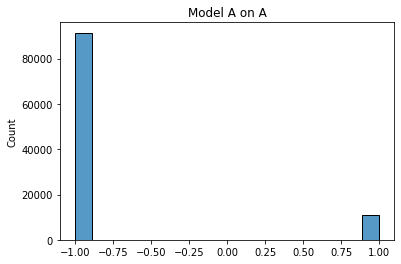

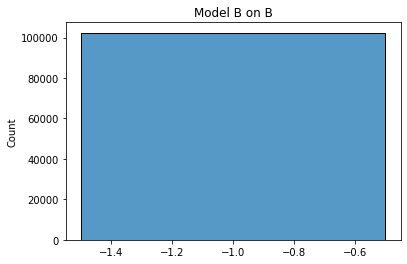

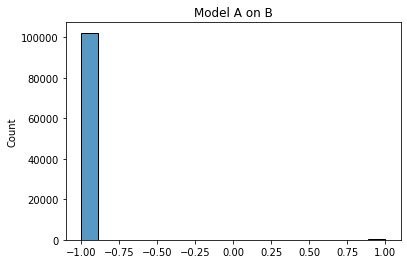

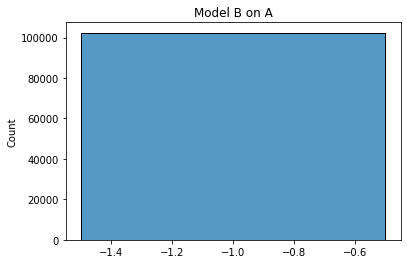

In [64]:
vizualize_iforest(df_A=df_cirq, df_B=df_qiskit)

In [71]:
iforest_bitstring_similarity(df_A=df_cirq, df_B=df_qiskit, n_rounds=5)

74397

## Score Distribution Similarity - Top K

In [66]:

m = df_qiskit.fillna(0).to_numpy()
solution_cum_freq = m.sum(axis=0)
most_frequent_solutions = np.argsort(solution_cum_freq)[::-1][:FIRST_K]
relevant_solutions = df_qiskit.columns[most_frequent_solutions]
freqs = solution_cum_freq[most_frequent_solutions]

In [73]:
df_relevant_qiskit = df_qiskit[relevant_solutions]
df_relevant_qiskit.head(3)

,1101001000,0011001000,0011100100,1101100100,0001001010
0,22,17,13,25,7
1,18,7,16,17,16
2,20,18,16,16,20


In [74]:
df_relevant_cirq = df_cirq[relevant_solutions]
df_relevant_cirq.head(3)

,1101001000,0011001000,0011100100,1101100100,0001001010
0,13,13,15,7,13
1,20,19,30,10,12
2,22,21,17,17,13


In [117]:
    
# compare the distribution of the occurrences of each basis state (e.g. 0000)
# for cirq (state: 0000): [512, 493, 502, etc ... until N_EVALUATION]
# for qiskit (state: 0000): [400, 475, 480, etc ... until N_EVALUATION]
# check if the two sequences come from the same distribution with a test
from scipy.stats import ttest_ind


def score(df_master, df_slave, first_k=TOP_K_SOLUTION_TO_COMPARE):
    # get the top k occurring solutions according to the master
    m = df_master.fillna(0).to_numpy()
    solution_cum_freq = m.sum(axis=0)
    most_frequent_solutions = np.argsort(solution_cum_freq)[::-1][:first_k]
    relevant_solutions = df_master.columns[most_frequent_solutions]
    freqs = solution_cum_freq[most_frequent_solutions]
    # compute p-values
    p_values = []
    df_master = df_master.fillna(0)
    df_slave = df_slave.fillna(0)
    for c in relevant_solutions:
        try:
            stat, p = ttest_ind(df_master[c], df_slave[c])
        except:
            if c not in df_master.columns:
                print(f"{c} column was missing from result of platform master")
                df_master[c] = 0
            if c not in df_slave.columns:
                print(f"{c} column was missing from result of platform slave")
                df_slave[c] = 0
            stat, p = ttest_ind(df_master[c], df_slave[c])    
        p_values.append(p)
    return min(p_values)
    
score(df_cirq, df_qiskit)

0.22879263925876986

In [ ]:
# if yes... then bug discovered!

# next steps:
    
    # which platform is buggy: cirq or qiskit?
    
    # where was the mistake in that platform?
    
        # delta debugging (style)
        
        # - remove operations
        # - track the function called with cProfile
        # - continue until the removed operation cause the Cirq an Qiskit result 
        # to agree again

## Searching Loop

In [72]:
N_TRIALS = 10
P_VALUE_THRESHOLD = 0.01

In [88]:
OUT_FOLDER = "../random_circuit_generated"

In [108]:
import datetime
import os

def save(encoding, score, folder=OUT_FOLDER):
    now = datetime.datetime.now()
    score = str(int(score))
    score = score.zfill(10)
    filename = score + "_" + '{:%Y-%m-%d %H:%M:%S}'.format(now) + "_" + str(int(encoding[0]*100))
    np.save(os.path.join(folder, filename), encoding, allow_pickle=False)


In [105]:
os.getcwd()

'/home/paltenmo/projects/ML4Quantum/notebooks'

In [113]:
for macro_i in range(N_TRIALS):
    print("-" * 80)
    print(f"Creating circuit number: #{macro_i}")
    
    # create a new random circuit
    numerical_encoding = random_circuit_encoding()
    random_circuit_qasm_str = encoding_to_circuit(
        encoding=numerical_encoding, 
        n_qubits=N_QUBITS, 
        classical_input=30)

    # evaluate circuits
    platforms = [QiskitCircuit(), CirqCircuit()]
    platform_result_dfs = []

    print(f"Running (via simulation) circuit #{macro_i}")
    # for each platform in (qiskit, cirq, etc)
    for p in platforms:
        print(p.platform_name)            

        # create a circuit object form the qasm file
        p.from_qasm(random_circuit_qasm_str)

        # perform 30 evaluations [N_EVALUATION]
        data = []
        for i in range(N_EVALUATIONS):
            # run the circuit for 1024 or 8096 shots
            p.execute()
            data.append(p.get_result())

        # save the statistics for each combination to a dataframe
        df = pd.DataFrame.from_records(data)
        platform_result_dfs.append(df)

    for df in platform_result_dfs:
        display(df.head())
    
    df_qiskit, df_cirq = platform_result_dfs 
    
    print(f"Computation of Cross-compiler Similarity Score for #{macro_i}")
    current_score = iforest_bitstring_similarity(df_A=df_cirq, df_B=df_qiskit, n_rounds=5)
    
    print(f"Saving circuit: #{macro_i} with score {current_score}")
    save(encoding=numerical_encoding, score=current_score)

Creating circuit number: 0
Running circuit number: 0
qiskit
cirq


,0100001011,1110101101,1101111011,0011000111,1011011100,1000010010,1101011110,0101000001,0000101011,0011111101,...,0010011000,1001011011,0000010000,0010001000,0100001100,0001001110,0100000001,0001101100,1101110010,0101011001
0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1100100110,1110000110,1001001101,1100100100,1011001101,1001000011,1100011011,1110010101,1100101100,1101010000,...,1101000101,0010001010,0001011011,0100001100,0000010000,0100000001,0101110000,0011010101,0101011011,0100101000
0,4,3.0,8,1.0,8,2.0,4,6,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,4.0,6,1.0,6,3.0,2,3,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,3.0,4,2.0,2,2.0,6,6,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2.0,11,1.0,6,5.0,5,3,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,1.0,6,1.0,6,5.0,8,7,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 0
Saving circuit i: 0
Creating circuit number: 1
Running circuit number: 1
qiskit
cirq


,1100110100,1010111011,0011011011,1111011001,0110100011,0010010000,0101100010,0111110010,0100101110,0110000001,...,1100101001,1000001101,0001001011,1001100010,1101101000,1001011000,0111110110,0101000100,1000100000,1000000100
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,1.0,2.0,3.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,2.0,4.0,6.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1101011000,1101001101,0010110000,1111000001,1001000110,0100001010,0111011011,0010010001,0000001011,0001010111,...,1011110110,0111101100,0101111100,0101001000,1011011100,0110011011,0000101110,0110000100,1111101100,1011110010
0,1.0,2.0,4,1.0,2.0,4.0,1.0,3.0,7,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,9,1.0,NaN,5.0,2.0,5.0,6,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,5,NaN,3.0,8.0,NaN,5.0,7,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,6,NaN,2.0,5.0,NaN,1.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,3,4.0,4.0,5.0,1.0,6.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 1
Saving circuit i: 1
Creating circuit number: 2
Running circuit number: 2
qiskit
cirq


,1111010110,1000100010,1100101110,1111010111,1011010110,1101010000,0110000100,1001111000,1101100010,1101010001,...,1000001111,0010110010,1101001010,1110101101,1011100001,1100100111,1001000011,1100001111,0100101111,0110100001
0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,5.0,4.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,NaN,3.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,1.0,6.0,9.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.0,1.0,NaN,3.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0000101011,0010001000,0110001000,1011100000,1010110011,1010000000,1000000011,0111001101,0000111000,0010100100,...,0000010001,0110010111,0010010010,0011110111,1011100001,1100101111,0001001010,0111011111,1101001110,1000001111
0,2.0,10,20,34,1.0,3,1.0,8.0,4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,6,34,35,3.0,2,2.0,3.0,11,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,11,32,31,2.0,5,NaN,5.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,4,30,24,2.0,4,1.0,4.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,6,29,28,2.0,6,2.0,3.0,5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 2
Saving circuit i: 2
Creating circuit number: 3
Running circuit number: 3
qiskit
cirq


,0001000101,1100001100,0101001100,1011101001,0111101100,1010101000,0010111001,0011011110,1110001000,0001000011,...,1001101010,1101000011,1000111101,1110100111,0101011101,0010011010,0000000000,1000100110,1011101111,1010101111
0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,NaN,4.0,2.0,2.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,3.0,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1110001100,0111010110,1110110110,0010011110,1000100100,1010110001,1111111010,0010100101,0110011010,0001101111,...,1000000000,0111100001,1101010111,1001110110,0000011101,0011101010,0111110110,1001000000,0001011101,1010010100
0,3.0,4.0,10,3.0,3.0,13,3.0,3.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,6.0,10,1.0,NaN,15,2.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,8,1.0,2.0,7,NaN,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.0,9,NaN,3.0,13,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,6.0,9,NaN,4.0,12,NaN,2.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 3
Saving circuit i: 3
Creating circuit number: 4
Running circuit number: 4
qiskit
cirq


,1100111101,0110110111,1101000110,1010001100,0010001100,0001101100,1011111010,1101110000,1100000110,0001101010,...,1010000000,1111101000,0111110010,0011110110,1000110000,1110111011,0000100000,0011101010,1000100000,0101010111
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,2.0,2.0,NaN,2.0,3.0,NaN,1.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0001100111,0010011111,0110101101,1100001011,0111011101,0100001101,0111011111,1101011111,1110001000,1011011101,...,0011001110,0010100110,0110110010,1000111000,1110000010,1100010100,0001100100,0111110010,1001001111,1110111011
0,9.0,20,6.0,4,5.0,4.0,9,1.0,6.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,18,3.0,7,6.0,2.0,6,2.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,22,4.0,7,1.0,3.0,7,1.0,2.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,14,2.0,11,5.0,3.0,6,2.0,1.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,19,2.0,4,3.0,5.0,16,1.0,1.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 4
Saving circuit i: 4
Creating circuit number: 5
Running circuit number: 5
qiskit
cirq


,1000100111,1010111010,1011000010,0111101000,0001001111,0100000101,1010111110,1101011110,1000011001,1100000011,...,1110011101,0001110101,1101011100,0001000111,1001011011,0101101100,0001100010,0001000101,0100100101,1101000010
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1010111001,0110101011,0000111001,0110001001,1010110001,1000010011,0010000110,0000011010,0000101111,1011101010,...,0000100101,1000101110,0101001100,0101111011,1000110110,0111000001,1001001101,0100110101,1000111101,1001010011
0,3.0,2.0,2.0,5.0,1.0,1.0,3.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,4.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,4.0,NaN,3.0,NaN,NaN,1.0,3.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1.0,NaN,3.0,NaN,1.0,2.0,3.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,NaN,1.0,NaN,3.0,2.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 5
Saving circuit i: 5
Creating circuit number: 6
Running circuit number: 6
qiskit
cirq


,0110010000,0111001001,0101110011,1111101011,0111101011,0011011000,1011010100,1010010111,1100110101,0111010101,...,0011011111,0100000001,0111010010,1110101000,1010111001,1110000011,1110101100,0101101010,0101000011,0000101110
0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,2.0,NaN,1.0,1.0,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0110100110,0100000100,1011100101,0101101101,1101011100,0011001101,1100000100,0011110101,0010000001,1000000100,...,0111010110,1111100111,1110101100,0001010010,1111110001,0000101110,1000110010,1010100011,1001100010,0110001010
0,1.0,5.0,18,7,4.0,2.0,2.0,2.0,4.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,22,6,2.0,3.0,3.0,NaN,1.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0,13,3,1.0,3.0,5.0,1.0,2.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,6.0,15,7,1.0,3.0,5.0,NaN,3.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,12,3,3.0,2.0,3.0,1.0,5.0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 6
Saving circuit i: 6
Creating circuit number: 7
Running circuit number: 7
qiskit
cirq


,1100000001,1000111000,0001011010,1010110110,1010010010,1011001010,0011001011,1100101101,0111110100,0101000010,...,0011011100,0100001100,0011101000,1011011101,1000100111,1001001100,0001111110,0010011110,1111100101,0111101000
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,NaN,1.0,3.0,2.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,1.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,2.0,5.0,1.0,NaN,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,1.0,NaN,2.0,1.0,NaN,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0001001001,0000110000,1010011110,0110000110,1110111100,1011100110,0000010001,1110000010,0001010001,1100001000,...,0011010100,1111100101,0010001001,0001100100,0001100110,1111100000,0000100111,1111011001,0111101001,0111110001
0,5,2.0,5.0,4.0,3.0,3.0,5.0,2.0,4.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,5.0,1.0,1.0,2.0,2.0,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,1.0,6.0,5.0,1.0,1.0,3.0,1.0,1.0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,1.0,5.0,3.0,3.0,1.0,2.0,NaN,1.0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,5.0,NaN,NaN,3.0,1.0,NaN,2.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 7
Saving circuit i: 7
Creating circuit number: 8
Running circuit number: 8
qiskit
cirq


,1010011101,1110101010,1101001101,0001011001,0010011000,0001000010,0110100100,1001011111,1010101110,0100111000,...,1111000101,0110110101,1011010001,0011011111,0011110001,0010010010,0111011110,0000010010,0110011011,0100110011
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1100010011,0111011111,1100110001,1110111000,1101010111,1100111111,1111111100,1111011011,1100110110,1010111101,...,0000010000,1101011110,0100110101,0110011011,0111111101,0101100100,0100011011,0110011110,0011000110,1100000101
0,4.0,1.0,2.0,4.0,1.0,8,2.0,6,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,1.0,1.0,1.0,1.0,8,4.0,8,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,3.0,2.0,NaN,10,2.0,1,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,2.0,1.0,4.0,1.0,8,3.0,6,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.0,5.0,NaN,7,4.0,8,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 8
Saving circuit i: 8
Creating circuit number: 9
Running circuit number: 9
qiskit
cirq


,0100011101,1111101101,0100000011,0010100111,1111011111,0011010001,1101110100,1111111101,0001011100,0000011100,...,1011011011,1101011101,1110101101,0110110100,0100111111,1000101111,1000110001,0000110111,0100101010,0101001110
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,3.0,NaN,1.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,2.0,NaN,5.0,NaN,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,NaN,1.0,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0111100010,1110101010,1011100010,1100110101,1010011111,0011010101,1111101010,0000100011,0101101001,0010000011,...,1011001111,0101001010,1110000101,0111001010,1101011101,0000110011,1011001101,1111101111,0100111110,1011011010
0,2.0,2.0,29,1.0,3.0,5.0,9,9,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2.0,28,NaN,5.0,2.0,4,11,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,9.0,25,NaN,4.0,6.0,6,6,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,7.0,29,NaN,6.0,6.0,7,8,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2.0,22,NaN,8.0,4.0,6,12,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comutation of Cross-compiler Similarity Score: 9
Saving circuit i: 9


In [111]:
save(encoding=random_circuit_encoding(), score=53333)
    

# Manual Run

In [114]:
encoding = np.load("../random_circuit_generated/0000005789_2021-10-27 12:44:40_15.npy")

In [115]:
qasm_str = encoding_to_circuit(
        encoding=encoding, 
        n_qubits=N_QUBITS, 
        classical_input=30)

In [116]:
# evaluate circuits
platforms = [QiskitCircuit(), CirqCircuit()]
platform_result_dfs = []

print(f"Running (via simulation) circuit ...")
# for each platform in (qiskit, cirq, etc)
for p in platforms:
    print(p.platform_name)            

    # create a circuit object form the qasm file
    p.from_qasm(qasm_str)

    # perform 30 evaluations [N_EVALUATION]
    data = []
    for i in range(N_EVALUATIONS):
        # run the circuit for 1024 or 8096 shots
        p.execute()
        data.append(p.get_result())

    # save the statistics for each combination to a dataframe
    df = pd.DataFrame.from_records(data)
    platform_result_dfs.append(df)

for df in platform_result_dfs:
    display(df.head())

df_qiskit, df_cirq = platform_result_dfs 

Running (via simulation) circuit ...
qiskit
cirq


,0111000100,0000101011,0111100011,0010011001,1001000110,1100100010,0100001111,0101010010,1111011110,1000010111,...,1011000100,0101011100,1011011010,0101011001,1011011000,0101111001,0101011101,1011001111,1100101101,0000110101
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2.0,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.0,1.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,6.0,NaN,NaN,2.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1010010111,1111101100,1010010100,1110110111,1101100010,1100000010,0011010001,1111011111,0001100011,0111100101,...,0101111001,0100101000,1101000100,0110110100,0111111100,1110000101,0100011011,0111011110,1011010010,0100111100
0,7.0,3.0,3.0,7,8.0,4,2.0,3.0,14,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.0,3.0,NaN,4,3.0,4,1.0,2.0,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,2.0,1.0,5,1.0,2,NaN,NaN,23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,4.0,1.0,7,5.0,3,NaN,NaN,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,2.0,NaN,6,2.0,4,1.0,2.0,23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
score(df_cirq, df_qiskit)

0.22879263925876986